In [1]:
# Gerekli Kütüphaneler
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
from torch.optim.lr_scheduler import StepLR
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn.functional as F

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.ESQVI9_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.ESQVI9_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
Train samples: 3750
Test samples: 1250

*** Eğitim Verisi Analizi ***
Toplam örnek sayısı: 3750
Sınıf bazında örnek sayıları:
  pizza: 750
  hamburger: 750
  ice_cream: 750
  french_fries: 750
  sushi: 750
Benzersiz görsel boyutları: {(380, 512, 3), (273, 512, 3), (512, 509, 3), (461, 512, 3), (286, 512, 3), (383, 512, 3), (410, 512, 3), (512, 445, 3), (360, 512, 3), (512, 339, 3), (512, 383, 3), (332, 512, 3), (304, 512, 3), (333, 512, 3), (492, 512, 3), (210, 512, 3), (512, 341, 3), (464, 512, 3), (375, 512, 3), (381, 512, 3), (512, 343, 3), (512, 464, 3), (512, 424, 3), (512, 307, 3), (287, 512, 3), (434, 512, 3), (384, 512, 3), (411, 512, 3), (512, 426, 3), (512, 505, 3), (508, 512, 3), (512, 386, 3), (239, 512, 3), (346, 512, 3), (308, 512, 3), (314, 512, 3), (432, 512, 3), (512, 348, 3), (512, 392, 3), (385, 512, 3), (344, 512, 3), (491, 512, 3), (382, 512, 3

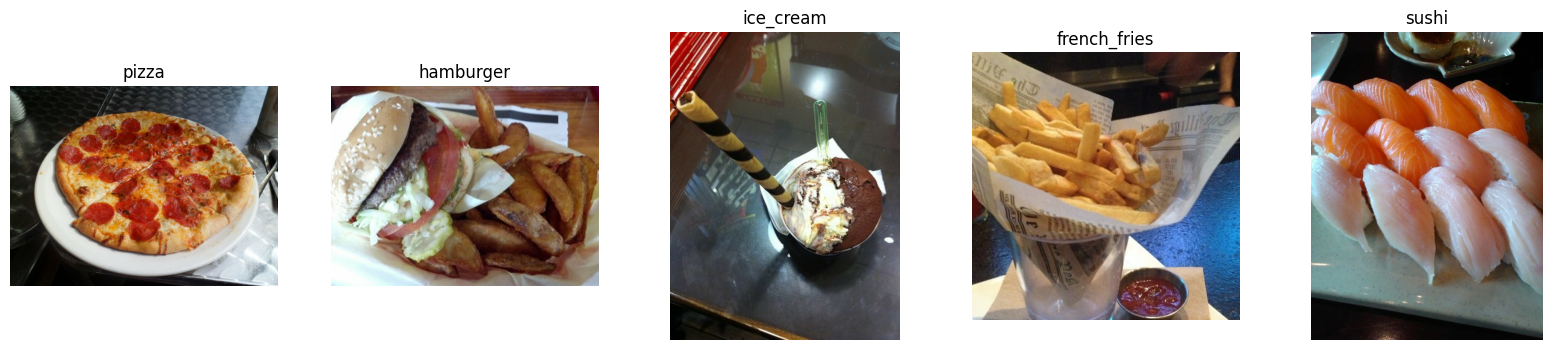


*** Test Verisi Analizi ***
Toplam örnek sayısı: 1250
Sınıf bazında örnek sayıları:
  hamburger: 250
  french_fries: 250
  pizza: 250
  sushi: 250
  ice_cream: 250
Benzersiz görsel boyutları: {(511, 512, 3), (342, 512, 3), (512, 509, 3), (512, 388, 3), (408, 512, 3), (383, 512, 3), (410, 512, 3), (393, 512, 3), (512, 379, 3), (512, 443, 3), (343, 512, 3), (512, 482, 3), (512, 306, 3), (366, 512, 3), (512, 383, 3), (385, 512, 3), (344, 512, 3), (442, 512, 3), (401, 512, 3), (406, 512, 3), (304, 512, 3), (469, 512, 3), (382, 512, 3), (333, 512, 3), (295, 512, 3), (512, 308, 3), (512, 341, 3), (512, 475, 3), (512, 288, 3), (381, 512, 3), (391, 512, 3), (306, 512, 3), (512, 499, 3), (341, 512, 3), (329, 512, 3), (307, 512, 3), (506, 512, 3), (510, 512, 3), (403, 512, 3), (512, 343, 3), (512, 510, 3), (512, 512, 3), (512, 382, 3), (484, 512, 3), (512, 307, 3), (287, 512, 3), (288, 512, 3), (384, 512, 3), (340, 512, 3), (512, 384, 3), (289, 512, 3), (509, 512, 3), (512, 342, 3), (512, 432, 

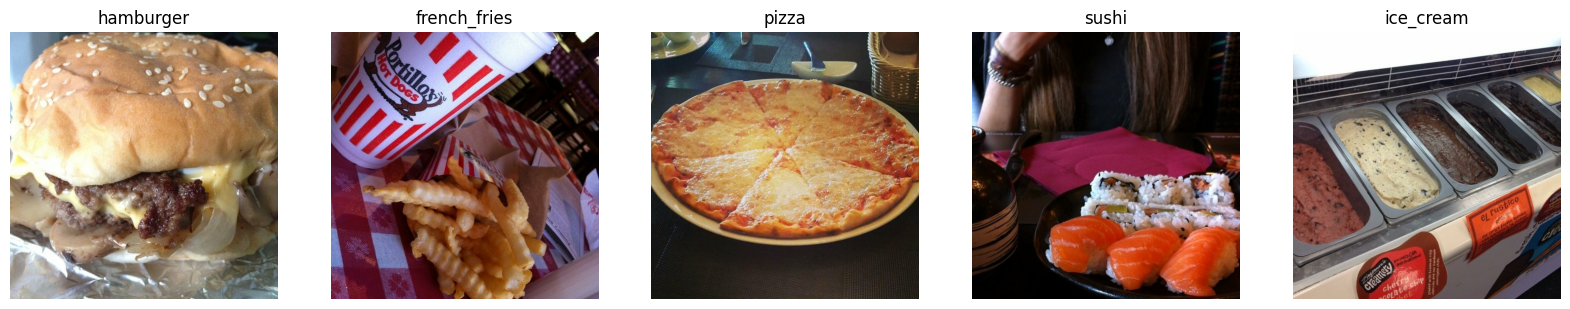

In [2]:
# --- Kullanılacak Sınıflar ---
selected_classes = ['pizza', 'hamburger', 'sushi', 'french_fries', 'ice_cream']

# --- Dataset Yükleme ---
dataset, info = tfds.load('food101', split=['train', 'validation'], as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset

# Label isimleri
label_names = info.features['label'].names

# Seçilen sınıfların dataset içindeki indeksleri
selected_indices = [label_names.index(cls) for cls in selected_classes]

# --- Dataset Filtreleme Fonksiyonu ---
def filter_and_convert(dataset):
    data = []
    for image, label in tfds.as_numpy(dataset):
        if label in selected_indices:
            class_name = label_names[label]  # Örnek: 'pizza'
            idx = selected_classes.index(class_name)  # 0, 1, 2, ...
            data.append((image, class_name, idx))
    return data

# --- Datasetleri Filtrele ve Listeye Yükle ---
train_data = filter_and_convert(train_dataset)
test_data = filter_and_convert(test_dataset)

print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

# --- Hızlı Veri Analizi Fonksiyonu ---
def veri_analizi(data, isim="Eğitim"):
    print(f"\n*** {isim} Verisi Analizi ***")

    toplam_ornek = len(data)
    print(f"Toplam örnek sayısı: {toplam_ornek}")

    # Her sınıfın örnek sayısını bul
    sinif_sayilari = Counter([item[1] for item in data])
    print("Sınıf bazında örnek sayıları:")
    for sinif, sayi in sinif_sayilari.items():
        print(f"  {sinif}: {sayi}")

    # Görsel boyutları
    boyutlar = [item[0].shape for item in data]
    benzersiz_boyutlar = set(boyutlar)
    print(f"Benzersiz görsel boyutları: {benzersiz_boyutlar}")

    # Ortalama yükseklik, genişlik, kanal sayısı
    yukseklikler = [b[0] for b in boyutlar]
    genislikler = [b[1] for b in boyutlar]
    kanallar = [b[2] for b in boyutlar]

    print(f"Ortalama yükseklik: {np.mean(yukseklikler):.2f}")
    print(f"Ortalama genişlik: {np.mean(genislikler):.2f}")
    print(f"Renk kanalları: {set(kanallar)}")

    # Her sınıftan bir örnek görselleştir
    kategoriler = {}
    for img, label, idx in data:
        if label not in kategoriler:
            kategoriler[label] = img
        if len(kategoriler) == len(sinif_sayilari):
            break

    n = len(kategoriler)
    fig, axs = plt.subplots(1, n, figsize=(4 * n, 4))
    if n == 1:
        axs = [axs]

    for i, (label, img) in enumerate(kategoriler.items()):
        axs[i].imshow(img)
        axs[i].set_title(label)
        axs[i].axis('off')
    plt.show()

# --- Eğitim ve Test Verisini Analiz Et ---
veri_analizi(train_data, "Eğitim")
veri_analizi(test_data, "Test")

In [3]:
# --- Test datasını Validation ve Test olarak ayırma ---
# %40 Validation, %60 Test olacak şekilde bölüyoruz
val_data, test_data_split = train_test_split(
    test_data,
    test_size=0.6,  # %60'ı test, %40'ı validation
    random_state=42,  # Tekrarlanabilir sonuç için sabit seed
    stratify=[item[1] for item in test_data]  # Sınıf dağılımını koru
)

print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data_split)}")

Validation samples: 500
Test samples: 750


In [4]:
# Transformlar
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class SimpleFoodDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, _, label = self.data[idx]  # class_name burada önemli değil, biz label index kullanacağız.
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
# Datasetleri oluştur
train_dataset = SimpleFoodDataset(train_data, transform=train_transform)
val_dataset = SimpleFoodDataset(val_data, transform=val_test_transform)
test_dataset = SimpleFoodDataset(test_data, transform=val_test_transform)

# DataLoader'lar
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Örnek batch çekelim
for images, labels in train_loader:
    print(images.shape)  # torch.Size([32, 3, 224, 224])
    print(labels.shape)  # torch.Size([32])
    break


torch.Size([32, 3, 224, 224])
torch.Size([32])


In [18]:
#validate Fonksiyonu (Modeli Test Etme)
def train_one_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

#Doğrulama Fonksiyonu (Precision, Recall, F1)
from sklearn.metrics import precision_score, recall_score, f1_score

def validate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    accuracy = 100. * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)

    return epoch_loss, accuracy, precision, recall, f1


In [7]:
#Model Tanımları ve Yükleyici Fonksiyonu

class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(p=0.2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(256)

        self.avg_pool1 = nn.AdaptiveAvgPool2d((107, 107))

        self.conv4 = nn.Conv2d(256, 256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(512)
        self.max3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv6 = nn.Conv2d(512, 128, kernel_size=3, stride=2)
        self.bn6 = nn.BatchNorm2d(128)
        self.max4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout()
        self.fc2 = nn.Linear(128, 6)  # 6 sınıf için

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(self.dropout3(x))

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.avg_pool1(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.max3(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        x = self.max4(x)

        x = self.avg_pool(x)
        x = x.view(-1, 128)
        x = self.fc1(x)
        x = F.relu(self.dropout(x))
        x = self.fc2(x)
        return x

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(p=0.2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(256)

        self.avg_pool1 = nn.AdaptiveAvgPool2d((107, 107))

        self.conv4 = nn.Conv2d(256, 256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(512)
        self.max3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv6 = nn.Conv2d(512, 128, kernel_size=3, stride=2)
        self.bn6 = nn.BatchNorm2d(128)
        self.max4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout()
        self.fc2 = nn.Linear(128, 6)  # 6 sınıf için

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(self.dropout3(x))

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.avg_pool1(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.max3(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        x = self.max4(x)

        x = self.avg_pool(x)
        x = x.view(-1, 128)
        x = self.fc1(x)
        x = F.relu(self.dropout(x))
        x = self.fc2(x)
        return x

class ResNetModel(nn.Module):
    def __init__(self, device="cuda:0"):
        super(ResNetModel, self).__init__()
        base_model = models.resnet18(pretrained=True)
        num_ftrs = base_model.fc.in_features
        base_model.fc = nn.Linear(num_ftrs, 6)  # 6 sınıf için
        self.model = base_model.to(device)

    def forward(self, x):
        return self.model(x)

class VGGModel(nn.Module):
    def __init__(self, device="cuda:0"):
        super(VGGModel, self).__init__()
        base_model = models.vgg16_bn(pretrained=True)
        base_model.classifier[6] = nn.Linear(4096, 6)  # 6 sınıf için
        base_model.classifier[6].weight.requires_grad = True
        base_model.classifier[6].bias.requires_grad = True
        self.model = base_model.to(device)

    def forward(self, x):
        return self.model(x)

def get_model(model_name, device="cuda:0"):
    if model_name == "baseline":
        return BaselineModel().to(device)
    elif model_name == "custom":
        return CustomModel().to(device)
    elif model_name == "resnet":
        return ResNetModel(device=device)
    elif model_name == "vgg":
        return VGGModel(device=device)
    else:
        raise ValueError(f"Model {model_name} not supported.")

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import os


# Mount drive before this (see step 1)
drive_save_dir = "/content/drive/MyDrive/food101_models"
os.makedirs(drive_save_dir, exist_ok=True)

model_names = ["resnet"]  # You can add others like "vgg", "baseline"
num_epochs = 30
early_stop_patience = 3

results = {}

for model_name in model_names:
    print(f"Training model: {model_name}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_model(model_name, device=device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    best_val_f1 = 0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_prec, val_recall, val_f1 = validate(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Val Precision: {val_prec:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        print("-" * 30)

        scheduler.step()

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            save_path = os.path.join(drive_save_dir, f"best_model_{model_name}.pth")
            torch.save(model.state_dict(), save_path)
            print(f"✅ Best model for {model_name} saved to {save_path}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s)")

        if epochs_no_improve >= early_stop_patience:
            print("⏹️ Early stopping triggered!")
            break

    results[model_name] = {
        "best_val_f1": best_val_f1,
        "final_val_acc": val_acc,
        "final_val_precision": val_prec,
        "final_val_recall": val_recall,
    }

    print(f"✅ Training finished for model {model_name}")
    print("=" * 40)

Training model: resnet


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30
Train Loss: 0.9850, Train Acc: 65.36%
Val Loss: 1.3209, Val Acc: 59.80%
Val Precision: 0.7420, Val Recall: 0.5980, Val F1: 0.5968
------------------------------
✅ Best model for resnet saved to /content/drive/MyDrive/food101_models/best_model_resnet.pth
Epoch 2/30
Train Loss: 0.7652, Train Acc: 72.77%
Val Loss: 0.8003, Val Acc: 70.60%
Val Precision: 0.7930, Val Recall: 0.7060, Val F1: 0.7011
------------------------------
✅ Best model for resnet saved to /content/drive/MyDrive/food101_models/best_model_resnet.pth
Epoch 3/30
Train Loss: 0.7290, Train Acc: 74.21%
Val Loss: 0.3633, Val Acc: 87.40%
Val Precision: 0.8759, Val Recall: 0.8740, Val F1: 0.8738
------------------------------
✅ Best model for resnet saved to /content/drive/MyDrive/food101_models/best_model_resnet.pth
Epoch 4/30
Train Loss: 0.6488, Train Acc: 77.95%
Val Loss: 0.3762, Val Acc: 85.60%
Val Precision: 0.8671, Val Recall: 0.8560, Val F1: 0.8567
------------------------------
No improvement for 1 epoch(s)
Epo

KeyboardInterrupt: 

In [16]:
file_path = "/content/drive/My Drive/food101_models/best_model_resnet.pth"


In [21]:
#En iyi modeli yükle
import torch

model.load_state_dict(torch.load("/content/drive/MyDrive/food101_models/best_model_resnet.pth"))
model.to(device)
model.eval()

ResNetModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [22]:
#Tüm doğrulama verileri üzerinde tahmin yap
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

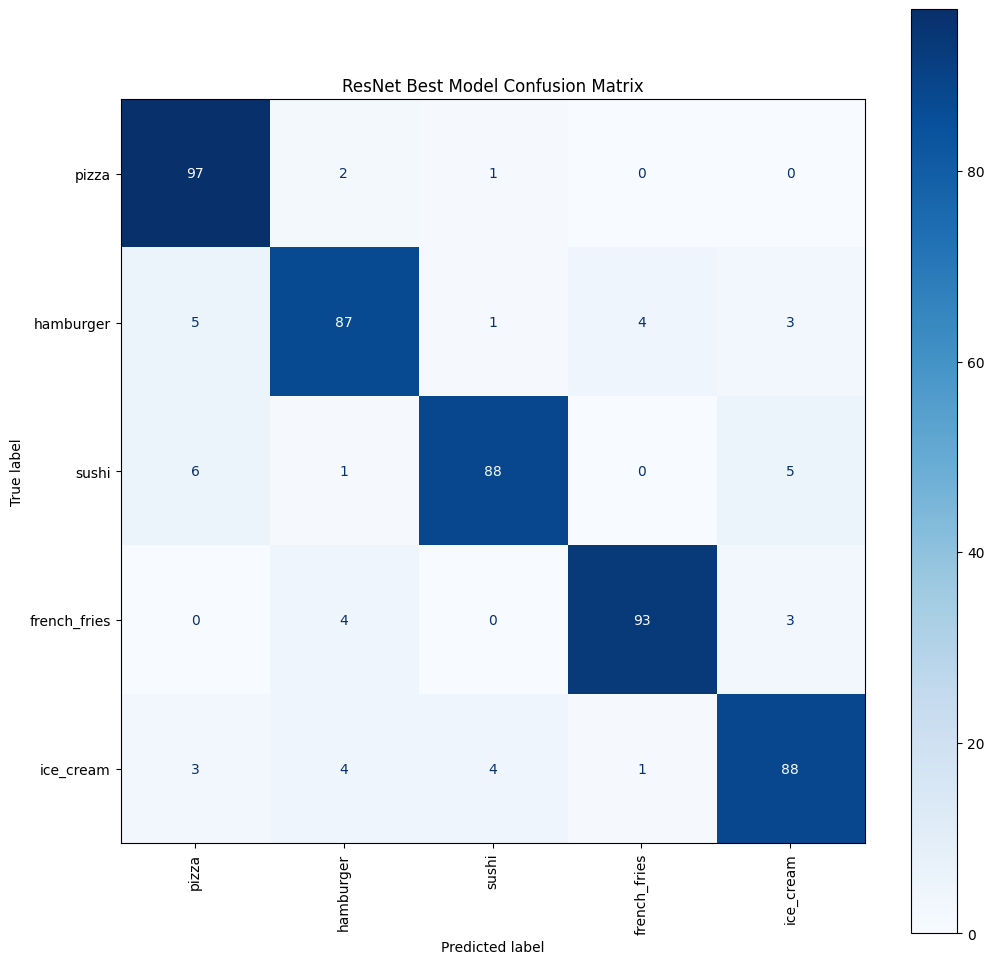

In [25]:
#Confusion matrix oluştur ve göster
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class_names = ['pizza', 'hamburger', 'sushi', 'french_fries', 'ice_cream']

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("ResNet Best Model Confusion Matrix")
plt.show()
